In [1]:
import scanpy as sc
import anndata as ad


In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

In [3]:
DATA_PATH = '/projectnb/czlab/A00/ycliu/scRNA_integration_benchmark_datasets/BMMC/'

OUTPUT_PATH = '/projectnb/czlab/A00/ycliu/scRNA_integration_benchmark_datasets/BMMC_Imbalance/'


# Load data

In [34]:
adata = sc.read_h5ad(DATA_PATH + 'bmmc.h5ad')

/usr2/postdoc/ycliu137/.conda/envs/scanpy_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [35]:
adata

AnnData object with n_obs × n_vars = 30669 × 14087
    obs: 'batch', 'labels'
    var: 'gene_id', 'gene_symbols', 'feature_types'

In [36]:
adata.obs['batch']

GCATTAGCATAAGCGG-1-s1d1    s1d1
TACAGGTGTTAGAGTA-1-s1d1    s1d1
AGGATCTAGGTCTACT-1-s1d1    s1d1
GTAGAAAGTGACACAG-1-s1d1    s1d1
TCCGAAAAGGATCATA-1-s1d1    s1d1
                           ... 
TAGATCGTCTCTATAC-1-s4d1    s4d1
AAGACTCAGGGCAAGG-1-s4d1    s4d1
CGAGAAGCACCTCGTT-1-s4d1    s4d1
TATCCTAGTTCTCCTG-1-s4d1    s4d1
TGCCGAGCAACAAAGT-1-s4d1    s4d1
Name: batch, Length: 30669, dtype: category
Categories (4, object): ['s1d1', 's2d1', 's3d1', 's4d1']

In [37]:
adata.var_names_make_unique()

In [38]:
adata

AnnData object with n_obs × n_vars = 30669 × 14087
    obs: 'batch', 'labels'
    var: 'gene_id', 'gene_symbols', 'feature_types'

# Remove cells

In [39]:
adata_0 = adata[adata.obs['batch'].isin(['s1d1', 's2d1'])]
adata_0

View of AnnData object with n_obs × n_vars = 15692 × 14087
    obs: 'batch', 'labels'
    var: 'gene_id', 'gene_symbols', 'feature_types'

In [40]:
adata_1 = adata[adata.obs['batch'].isin(['s3d1', 's4d1'])]
adata_1

View of AnnData object with n_obs × n_vars = 14977 × 14087
    obs: 'batch', 'labels'
    var: 'gene_id', 'gene_symbols', 'feature_types'

In [41]:
adata_0.obs['labels'].value_counts()

labels
CD14+ Mono                      3692
CD4+ T naive                    1474
Erythroblast                    1430
CD4+ T activated                1071
Naive CD20+ B IGKC+             1039
Reticulocyte                     875
Naive CD20+ B IGKC-              710
CD8+ T naive                     541
Normoblast                       455
pDC                              389
NK CD158e1+                      378
NK                               376
CD16+ Mono                       316
T reg                            284
CD4+ T activated integrinB7+     229
HSC                              203
cDC2                             201
Proerythroblast                  192
CD8+ T CD69+ CD45RA+             179
Lymph prog                       157
CD8+ T TIGIT+ CD45RO+            153
CD8+ T CD69+ CD45RO+             143
B1 B IGKC+                       143
CD8+ T CD49f+                    122
Transitional B                   119
B1 B IGKC-                        91
Plasma cell IGKC-              

In [42]:
adata_1.obs['labels'].value_counts()

labels
CD14+ Mono                      3552
CD4+ T activated                1393
CD4+ T naive                    1264
Reticulocyte                     781
Erythroblast                     772
Naive CD20+ B IGKC+              624
NK                               595
CD16+ Mono                       549
CD8+ T naive                     528
G/M prog                         451
cDC2                             345
Normoblast                       319
pDC                              307
NK CD158e1+                      298
Lymph prog                       292
HSC                              252
Proerythroblast                  243
Naive CD20+ B IGKC-              235
CD4+ T activated integrinB7+     188
B1 B IGKC+                       185
CD8+ T CD49f+                    169
Transitional B                   155
CD8+ T CD69+ CD45RO+             153
B1 B IGKC-                       148
T reg                            145
CD8+ T TIGIT+ CD45RO+            114
MK/E prog                      

In [43]:
adata_0 = adata_0[~adata_0.obs['labels'].isin(['CD16+ Mono', 'G/M prog', 'cDC2'])]
adata_1 = adata_1[~adata_1.obs['labels'].isin(['CD14+ Mono'])]

In [44]:
adata_0 = adata_0[~adata_0.obs['labels'].isin(['Reticulocyte'])]
adata_1 = adata_1[~adata_1.obs['labels'].isin(['Erythroblast'])]

In [45]:
adata_0

View of AnnData object with n_obs × n_vars = 14234 × 14087
    obs: 'batch', 'labels'
    var: 'gene_id', 'gene_symbols', 'feature_types'

In [46]:
adata_1

View of AnnData object with n_obs × n_vars = 10653 × 14087
    obs: 'batch', 'labels'
    var: 'gene_id', 'gene_symbols', 'feature_types'

In [47]:
adata = ad.concat([adata_0, adata_1], merge='same')
adata

AnnData object with n_obs × n_vars = 24887 × 14087
    obs: 'batch', 'labels'
    var: 'gene_id', 'gene_symbols', 'feature_types'

## Save anndata

In [48]:
adata.write(OUTPUT_PATH+'bmmc_imbalance.h5ad')

## Save 10X data

In [49]:
import scipy.io
from scipy.sparse import csr_matrix
import numpy as np
import gzip

def save_10X_data(path, data, X_sparse=False):
    """
    args:   path, data. data included three numpy array valued components (counts_matrix, genes, cells).
    """
    counts_matrix, genes, cells = data # 
    
    # compress counts_matrix
    if X_sparse:
        counts_matrix = counts_matrix.T
    else:
        counts_matrix = csr_matrix(counts_matrix).T
    
    with gzip.open(path+'matrix.mtx.gz', 'wb') as f:
        scipy.io.mmwrite(f, counts_matrix)
        
    with gzip.open(path+'features.tsv.gz', 'wt') as f:
        np.savetxt(f, genes, delimiter='\t', fmt='%s')
        
    with gzip.open(path+'barcodes.tsv.gz', 'wt') as f:
        np.savetxt(f, cells, delimiter='\t', fmt='%s')

In [50]:
import numpy as np
counts_matrix = adata.X
genes = np.array(adata.var)
cells = np.array(adata.obs.index)
labels =  np.array(adata.obs['labels'])
batch = np.array(adata.obs['batch'])

In [51]:
data = counts_matrix, genes, cells
save_10X_data(OUTPUT_PATH, data, X_sparse=True)

In [52]:
np.savetxt(OUTPUT_PATH+'labels.csv', labels, delimiter='\t', fmt='%s')
np.savetxt(OUTPUT_PATH+'batch.csv', batch, delimiter='\t', fmt='%s')

## Check 10X data

In [53]:
adata_10X = sc.read_10x_mtx(OUTPUT_PATH)
adata_10X

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


AnnData object with n_obs × n_vars = 24887 × 14087
    var: 'gene_ids', 'feature_types'

In [54]:
import pandas as pd
import numpy as np

df = pd.read_csv(OUTPUT_PATH+'batch.csv', sep='\t', header=None)

adata_10X.obs['batch'] = np.array(df)[:,0]
adata_10X.obs['batch'] = adata_10X.obs['batch'].astype('category')


df = pd.read_csv(OUTPUT_PATH+'labels.csv', sep='\t', header=None)
df
adata_10X.obs['labels'] = np.array(df)[:,0]
adata_10X.obs['labels'] = adata_10X.obs['labels'].astype('category')


In [55]:
adata_10X.var

,gene_ids,feature_types
AL627309.5,ENSG00000241860,Gene Expression
LINC01409,ENSG00000237491,Gene Expression
LINC01128,ENSG00000228794,Gene Expression
LINC00115,ENSG00000225880,Gene Expression
FAM41C,ENSG00000230368,Gene Expression
...,...,...
HLA-E-1,ENSG00000204592,Gene Expression
CD82-1,ENSG00000085117,Gene Expression
CD101-1,ENSG00000134256,Gene Expression
CD88,NaN,Gene Expression


In [56]:
adata_10X.obs

,batch,labels
GCATTAGCATAAGCGG-1-s1d1,s1d1,Naive CD20+ B IGKC+
TACAGGTGTTAGAGTA-1-s1d1,s1d1,CD14+ Mono
AGGATCTAGGTCTACT-1-s1d1,s1d1,Naive CD20+ B IGKC+
GTAGAAAGTGACACAG-1-s1d1,s1d1,HSC
CTCCCAATCCATTGGA-1-s1d1,s1d1,Normoblast
...,...,...
TAGATCGTCTCTATAC-1-s4d1,s4d1,NK
AAGACTCAGGGCAAGG-1-s4d1,s4d1,NK CD158e1+
CGAGAAGCACCTCGTT-1-s4d1,s4d1,Plasma cell IGKC+
TATCCTAGTTCTCCTG-1-s4d1,s4d1,Naive CD20+ B IGKC-


## Check anndata

In [57]:
adata = sc.read_h5ad(OUTPUT_PATH+ 'bmmc_imbalance.h5ad')
adata

AnnData object with n_obs × n_vars = 24887 × 14087
    obs: 'batch', 'labels'
    var: 'gene_id', 'gene_symbols', 'feature_types'

In [58]:
adata.var

,gene_id,gene_symbols,feature_types
AL627309.5,ENSG00000241860,AL627309.5,Gene Expression
LINC01409,ENSG00000237491,LINC01409,Gene Expression
LINC01128,ENSG00000228794,LINC01128,Gene Expression
LINC00115,ENSG00000225880,LINC00115,Gene Expression
FAM41C,ENSG00000230368,FAM41C,Gene Expression
...,...,...,...
HLA-E-1,ENSG00000204592,HLA-E,Gene Expression
CD82-1,ENSG00000085117,CD82,Gene Expression
CD101-1,ENSG00000134256,CD101,Gene Expression
CD88,NaN,CD88,Gene Expression


In [59]:
adata.obs

,batch,labels
GCATTAGCATAAGCGG-1-s1d1,s1d1,Naive CD20+ B IGKC+
TACAGGTGTTAGAGTA-1-s1d1,s1d1,CD14+ Mono
AGGATCTAGGTCTACT-1-s1d1,s1d1,Naive CD20+ B IGKC+
GTAGAAAGTGACACAG-1-s1d1,s1d1,HSC
CTCCCAATCCATTGGA-1-s1d1,s1d1,Normoblast
...,...,...
TAGATCGTCTCTATAC-1-s4d1,s4d1,NK
AAGACTCAGGGCAAGG-1-s4d1,s4d1,NK CD158e1+
CGAGAAGCACCTCGTT-1-s4d1,s4d1,Plasma cell IGKC+
TATCCTAGTTCTCCTG-1-s4d1,s4d1,Naive CD20+ B IGKC-


# Preprocess

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby("mean_bin")["dispersions"]


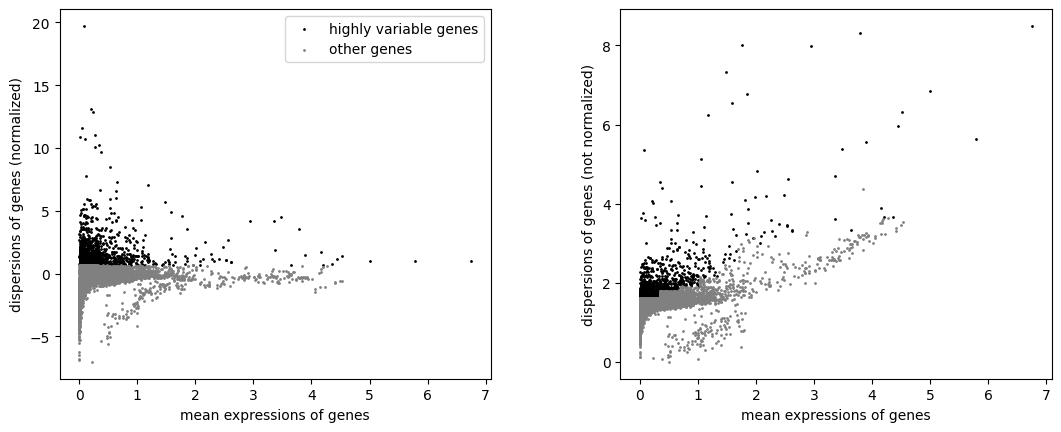

In [82]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [83]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


# Scanpy embeddings

In [84]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:39)


/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

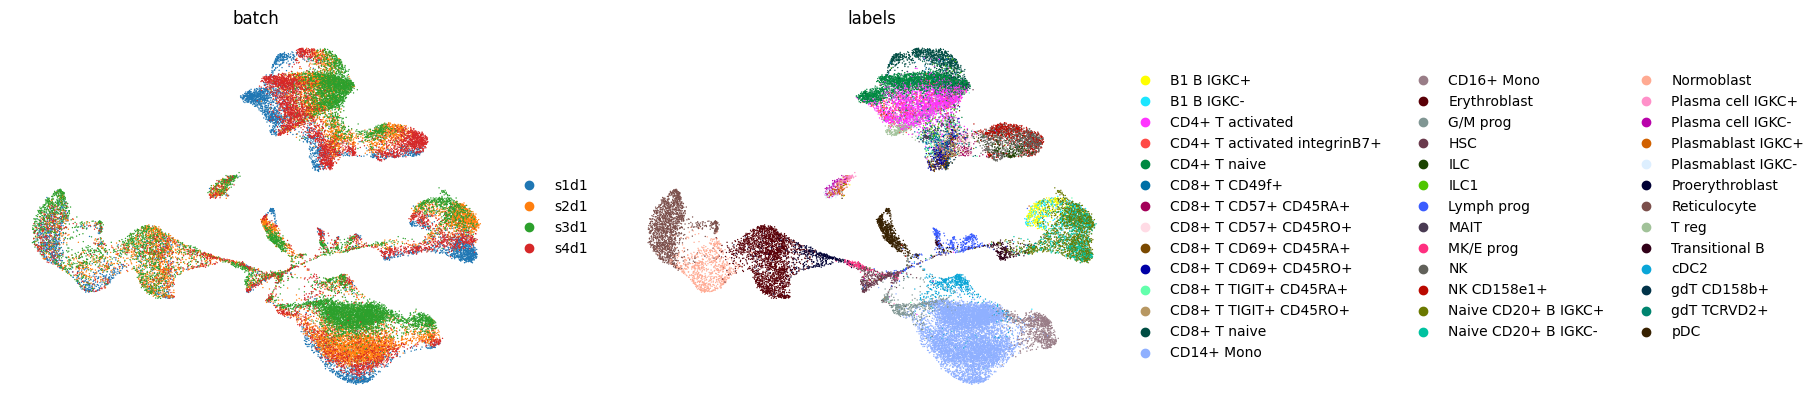

In [85]:
sc.pl.umap(adata, color=['batch', 'labels'], frameon=False)

# Harmony Integration

In [28]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:10)


In [29]:
# Batch correction with Harmony
sc.external.pp.harmony_integrate(adata, 'batch')

2024-05-13 14:58:48,027 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-13 14:58:54,578 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-13 14:58:54,685 - harmonypy - INFO - Iteration 1 of 10
2024-05-13 14:59:01,086 - harmonypy - INFO - Iteration 2 of 10
2024-05-13 14:59:07,545 - harmonypy - INFO - Iteration 3 of 10
2024-05-13 14:59:13,647 - harmonypy - INFO - Iteration 4 of 10
2024-05-13 14:59:17,779 - harmonypy - INFO - Iteration 5 of 10
2024-05-13 14:59:21,044 - harmonypy - INFO - Iteration 6 of 10
2024-05-13 14:59:23,168 - harmonypy - INFO - Iteration 7 of 10
2024-05-13 14:59:25,303 - harmonypy - INFO - Iteration 8 of 10
2024-05-13 14:59:27,427 - harmonypy - INFO - Iteration 9 of 10
2024-05-13 14:59:29,541 - harmonypy - INFO - Iteration 10 of 10
2024-05-13 14:59:31,668 - harmonypy - INFO - Converged after 10 iterations


In [30]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


In [91]:
import numpy as np

unique_elements, counts = np.unique(adata.obs['labels'], return_counts=True)

for element, count in zip(unique_elements, counts):
    print(f"{element}:  {count}")

B1 B IGKC+:  328
B1 B IGKC-:  239
CD14+ Mono:  7244
CD16+ Mono:  865
CD4+ T activated:  2464
CD4+ T activated integrinB7+:  417
CD4+ T naive:  2738
CD8+ T CD49f+:  291
CD8+ T CD57+ CD45RA+:  116
CD8+ T CD57+ CD45RO+:  119
CD8+ T CD69+ CD45RA+:  278
CD8+ T CD69+ CD45RO+:  296
CD8+ T TIGIT+ CD45RA+:  109
CD8+ T TIGIT+ CD45RO+:  267
CD8+ T naive:  1069
Erythroblast:  2202
G/M prog:  517
HSC:  455
ILC:  151
ILC1:  114
Lymph prog:  449
MAIT:  125
MK/E prog:  169
NK:  971
NK CD158e1+:  676
Naive CD20+ B IGKC+:  1663
Naive CD20+ B IGKC-:  945
Normoblast:  774
Plasma cell IGKC+:  137
Plasma cell IGKC-:  132
Plasmablast IGKC+:  121
Plasmablast IGKC-:  74
Proerythroblast:  435
Reticulocyte:  1656
T reg:  429
Transitional B:  274
cDC2:  546
gdT CD158b+:  37
gdT TCRVD2+:  81
pDC:  696


/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/projectnb/czproj/ycliu137/.conda/envs/scanpy_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warn

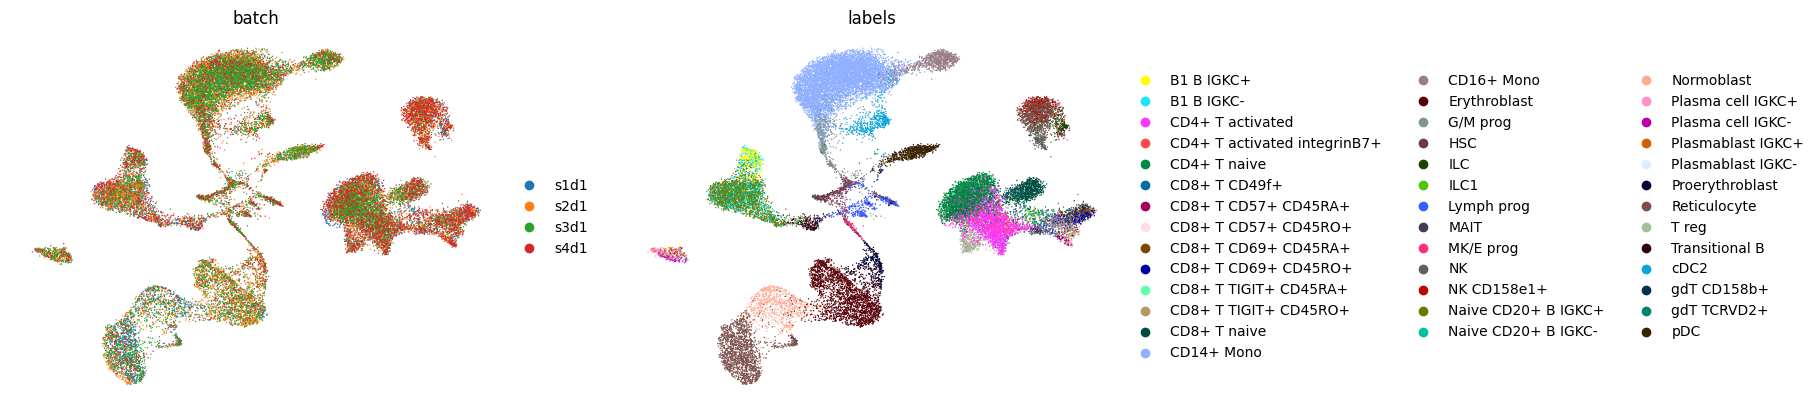

In [31]:
sc.pl.umap(adata, color=['batch', 'labels'], frameon=False)

/scratch/7172099.1.v100/ipykernel_347269/4106788277.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
/scratch/7172099.1.v100/ipykernel_347269/4106788277.py:3: SettingWithCopyWarn

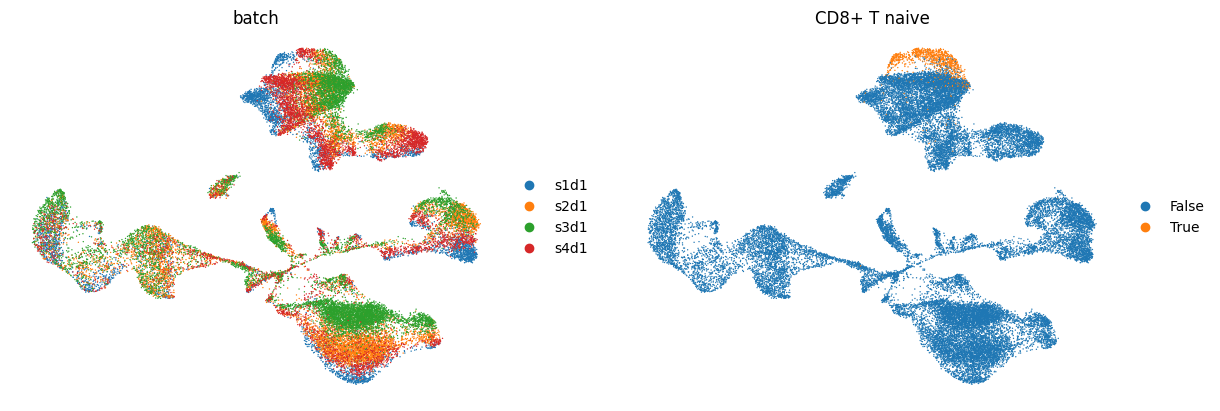

In [86]:
cell_type = 'CD8+ T naive'
adata.obs[cell_type] = 'False'
adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
sc.pl.umap(adata, color=['batch', cell_type], frameon=False)

/scratch/7172099.1.v100/ipykernel_347269/4257950309.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
/scratch/7172099.1.v100/ipykernel_347269/4257950309.py:3: SettingWithCopyWarn

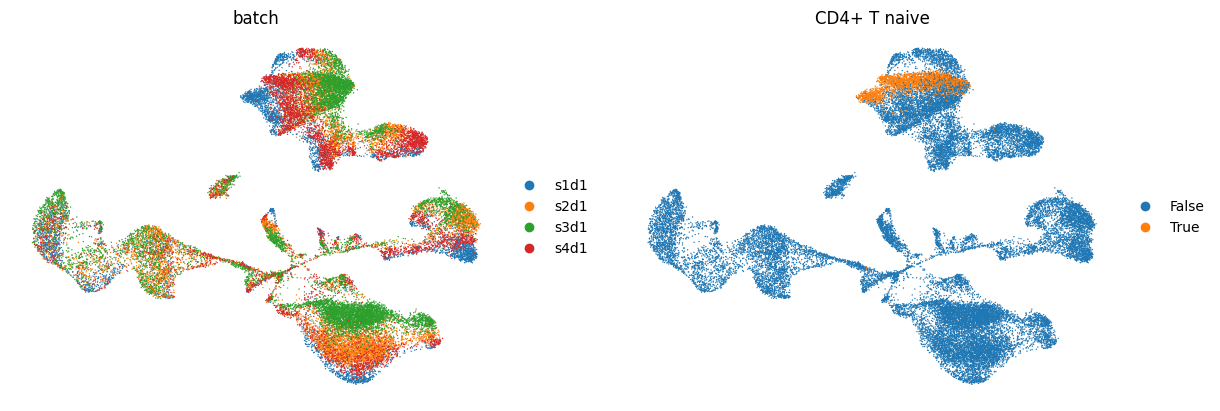

In [88]:
cell_type = 'CD4+ T naive'
adata.obs[cell_type] = 'False'
adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
sc.pl.umap(adata, color=['batch', cell_type], frameon=False)

/scratch/7172099.1.v100/ipykernel_347269/3711711508.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
/scratch/7172099.1.v100/ipykernel_347269/3711711508.py:3: SettingWithCopyWarn

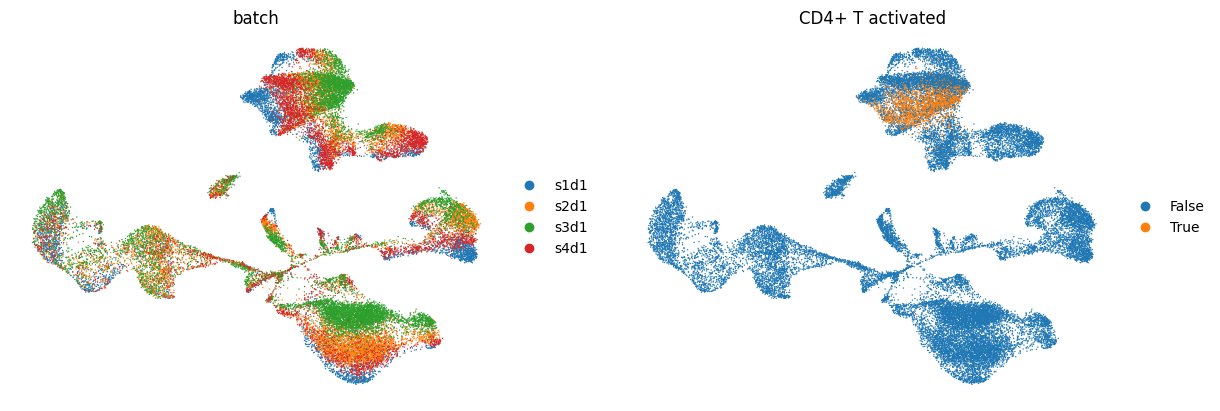

In [89]:
cell_type = 'CD4+ T activated'
adata.obs[cell_type] = 'False'
adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
sc.pl.umap(adata, color=['batch', cell_type], frameon=False)

/scratch/7172099.1.v100/ipykernel_347269/2304077904.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
/scratch/7172099.1.v100/ipykernel_347269/2304077904.py:3: SettingWithCopyWarn

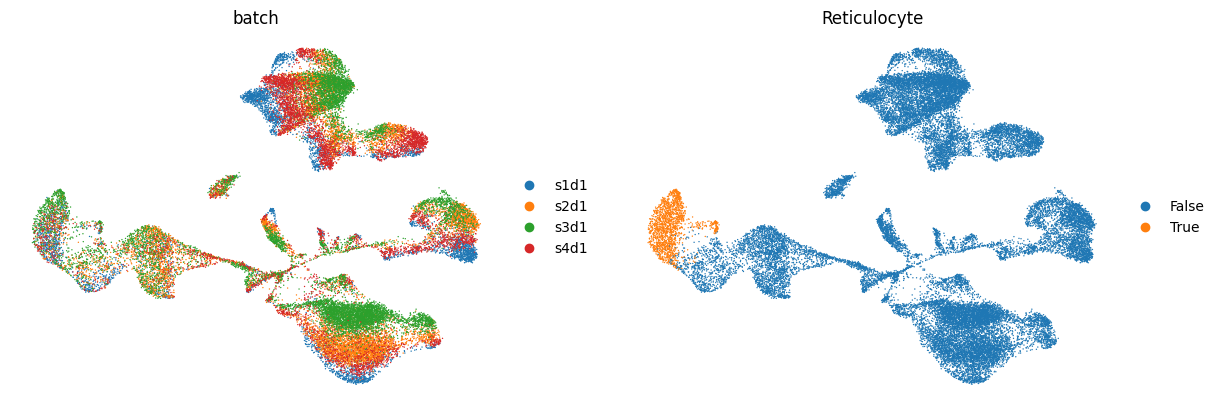

In [92]:
cell_type = 'Reticulocyte'
adata.obs[cell_type] = 'False'
adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
sc.pl.umap(adata, color=['batch', cell_type], frameon=False)

/scratch/7172099.1.v100/ipykernel_347269/1460748161.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
/scratch/7172099.1.v100/ipykernel_347269/1460748161.py:3: SettingWithCopyWarn

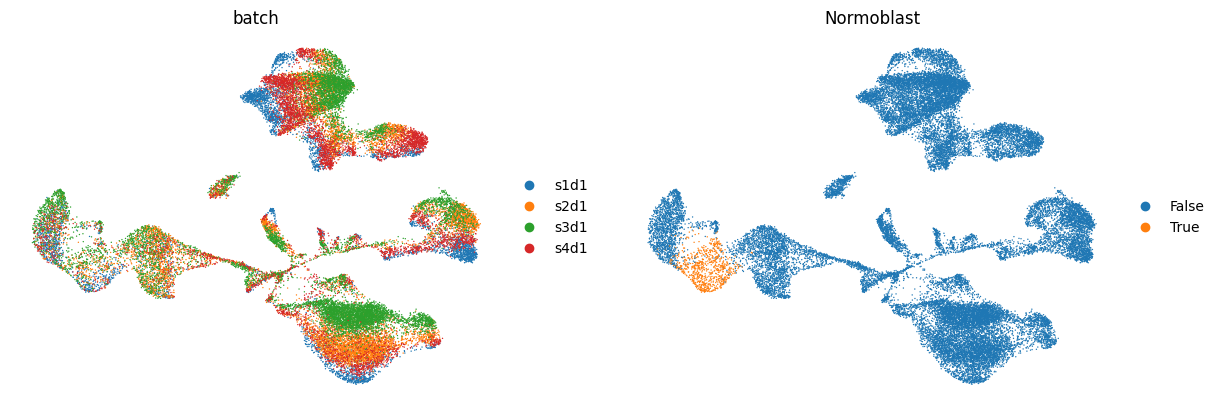

In [93]:
cell_type = 'Normoblast'
adata.obs[cell_type] = 'False'
adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
sc.pl.umap(adata, color=['batch', cell_type], frameon=False)

/scratch/7172099.1.v100/ipykernel_347269/2626493014.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
/scratch/7172099.1.v100/ipykernel_347269/2626493014.py:3: SettingWithCopyWarn

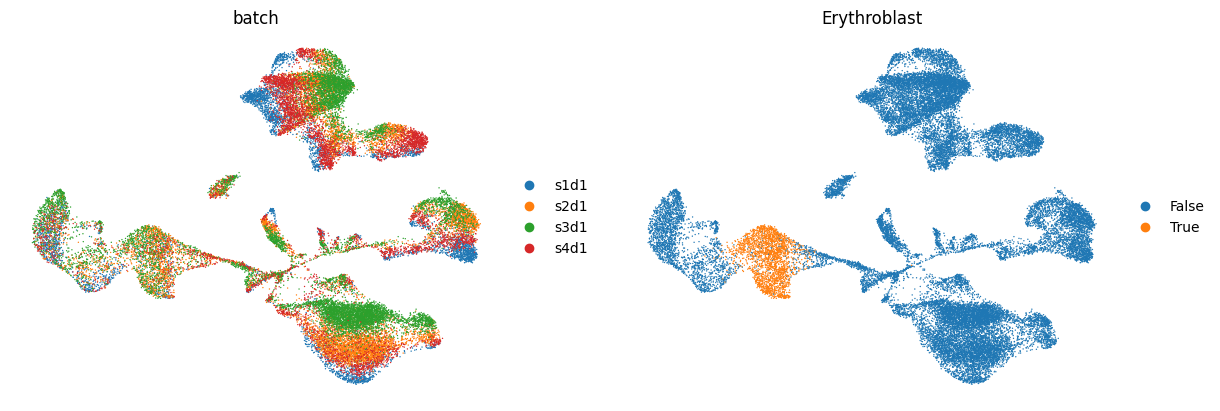

In [94]:
cell_type = 'Erythroblast'
adata.obs[cell_type] = 'False'
adata.obs[cell_type][adata.obs['labels']==cell_type]='True'
sc.pl.umap(adata, color=['batch', cell_type], frameon=False)